# Clustering Uber's Trip Data with Apache Spark

## CLUSTERING

The original Scala based tutorial on Zeppelin Notebooks is at https://mapr.com/blog/monitoring-real-time-uber-data-using-spark-machine-learning-streaming-and-kafka-api-part-1/. I have coverted them to Python and also configured to run the codes on Jupter Notebooks with Pyspark 2.2 and used the Jupyter Notebook to render visualization and added more stuffs.

Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters). It is a main task of exploratory data mining, and a common technique for statistical data analysis, used in many fields, including machine learning, pattern recognition, image analysis, information retrieval, bioinformatics, data compression, and computer graphics. [Source:https://en.wikipedia.org/wiki/Cluster_analysis]

We will discover the clusters of Uber data based on the longitude and latitude, then we will analyze the cluster centers by date/time.

## 1. Understanding the Data Set

Our data is Uber trip data from http://data.beta.nyc/dataset/uber-trip-data-foiled-apr-sep-2014. In this example, we will discover the clusters of Uber data based on the longitude and latitude, then we will analyze the cluster centers by date/time. The data set has the following schema:.

<p style="text-align: justify;"></p>
<pre>
<strong>Date/Time:</strong>The date and time of the Uber pickup
<strong>Lat:</strong>The latitude of the Uber pickup
<strong>Lon:</strong>The longitude of the Uber pickup
<strong>Base:</strong>The TLC base company affiliated with the Uber pickup
</pre>

The Data Records are in CSV format. An example line is shown below:

`2014-08-01 00:00:00,40.729,-73.9422,B02598`

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture

In [2]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 4))

import seaborn as sns
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

np.set_printoptions(precision=4, suppress=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 2. Creating the Spark Session

In [4]:
# The following must be set in your .bashrc file
#SPARK_HOME="/home/ubuntu/spark-2.4.0-bin-hadoop2.7"
#ANACONDA_HOME="/home/ubuntu/anaconda3/envs/pyspark"
#PYSPARK_PYTHON="$ANACONDA_HOME/bin/python"
#PYSPARK_DRIVER_PYTHON="$ANACONDA_HOME/bin/python"
#PYTHONPATH="$ANACONDA_HOME/bin/python"
#export PATH="$ANACONDA_HOME/bin:$SPARK_HOME/bin:$PATH"

In [5]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("cluster-uber-trip-data")
         .getOrCreate())
spark

## 3. Load The Data From a File Into a Dataframe

In [6]:
UBER_DATA = 'data/uber.csv'

In [7]:
# define the schema, corresponding to a line in the JSON data file.
schema = StructType([
    StructField("dt", TimestampType(), nullable=False),
    StructField("lat", DoubleType(), nullable=False),
    StructField("lon", DoubleType(), nullable=False),
    StructField("base", StringType(), nullable=True)]
  )

In [8]:
# Load training data
uber_df = spark.read.csv(path=UBER_DATA, schema=schema)
uber_df.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string]

In [9]:
uber_df.show(10)

+-------------------+-------+--------+------+
|                 dt|    lat|     lon|  base|
+-------------------+-------+--------+------+
|2014-08-01 00:00:00| 40.729|-73.9422|B02598|
|2014-08-01 00:00:00|40.7476|-73.9871|B02598|
|2014-08-01 00:00:00|40.7424|-74.0044|B02598|
|2014-08-01 00:00:00| 40.751|-73.9869|B02598|
|2014-08-01 00:00:00|40.7406|-73.9902|B02598|
|2014-08-01 00:00:00|40.6994|-73.9591|B02617|
|2014-08-01 00:00:00|40.6917|-73.9398|B02617|
|2014-08-01 00:00:00|40.7063|-73.9223|B02617|
|2014-08-01 00:00:00|40.6759|-74.0168|B02617|
|2014-08-01 00:00:00|40.7617|-73.9847|B02617|
+-------------------+-------+--------+------+
only showing top 10 rows



In [10]:
uber_df.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- base: string (nullable = true)



In [11]:
# How may Records?
uber_df.count()

829275

### Summary Statistics

Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame.

In [12]:
uber_df.describe(["dt", "lat", "lon"]).show()

+-------+------------------+--------------------+
|summary|               lat|                 lon|
+-------+------------------+--------------------+
|  count|            829275|              829275|
|   mean|40.737780735823684|  -73.97016031316477|
| stddev|0.0436280608468733|0.061482728345184666|
|    min|           39.6569|            -74.7737|
|    max|           41.3182|            -72.3359|
+-------+------------------+--------------------+



## 4. Prepare Train and Test Set

**4.1 Define Features Array:**

In [13]:
feature_columns = ['lat', 'lon']

In [14]:
# Vectorize the numerical features first
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [15]:
uber_assembled_df = feature_assembler.transform(uber_df)
uber_assembled_df.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

In [16]:
uber_assembled_df.show(10)

+-------------------+-------+--------+------+------------------+
|                 dt|    lat|     lon|  base|          features|
+-------------------+-------+--------+------+------------------+
|2014-08-01 00:00:00| 40.729|-73.9422|B02598| [40.729,-73.9422]|
|2014-08-01 00:00:00|40.7476|-73.9871|B02598|[40.7476,-73.9871]|
|2014-08-01 00:00:00|40.7424|-74.0044|B02598|[40.7424,-74.0044]|
|2014-08-01 00:00:00| 40.751|-73.9869|B02598| [40.751,-73.9869]|
|2014-08-01 00:00:00|40.7406|-73.9902|B02598|[40.7406,-73.9902]|
|2014-08-01 00:00:00|40.6994|-73.9591|B02617|[40.6994,-73.9591]|
|2014-08-01 00:00:00|40.6917|-73.9398|B02617|[40.6917,-73.9398]|
|2014-08-01 00:00:00|40.7063|-73.9223|B02617|[40.7063,-73.9223]|
|2014-08-01 00:00:00|40.6759|-74.0168|B02617|[40.6759,-74.0168]|
|2014-08-01 00:00:00|40.7617|-73.9847|B02617|[40.7617,-73.9847]|
+-------------------+-------+--------+------+------------------+
only showing top 10 rows



**4.2 Split into Training and Testing Set:**

In [17]:
train_df, test_df = uber_assembled_df.randomSplit([0.7, 0.3], seed=rnd_seed)

In [18]:
# cache the training and testing set
train_df.cache()
test_df.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

In [19]:
# remove the not needed dataframes
uber_df.unpersist()
uber_assembled_df.unpersist()

DataFrame[dt: timestamp, lat: double, lon: double, base: string]

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector]

## 5. k-means

`k-means` is one of the most popular clustering algorithms. In this algorithm, a user-specified number of clusters `(k)` are randomly assigned to different points in the dataset. The unassigned points are then "assigned" to a cluster based on their proximity (measured in Euclidean distance) to the previously assigned point. Once this assignment happens, the center of this cluster (called the `centroid`) is computed, and the process repeats. All points are assigned to a particular centroid, and a new centroid is computed. We repeat this process for a finite number of iterations or until convergence (i.e., when our centroid locations stop changing). This does not, however, mean that our clusters are always sensical. For instance, a given "logical" cluster of data might be split right down the middle simply because of the starting points of two distinct clusters. Thus, it is often a good idea to perform multiple runs of k-means starting with different initializations.

Choosing the right value for `k` is an extremely important aspect of using this algorithm successfully, as well as a hard task. There’s no real prescription for the number of clusters you need, so we’ll likely have to experiment with different values and consider what we would like the end result to be.

### 5.1 Train k-Means:

In [20]:
kmeans = KMeans(k=8, initMode='k-means||', featuresCol='features', predictionCol='cluster', maxIter=10)

In [21]:
kmModel = kmeans.fit(train_df)

In [22]:
print("KMeans Cluster Centers: ")
for center in kmModel.clusterCenters():
    print(center)

KMeans Cluster Centers: 
[ 40.7285 -74.005 ]
[ 40.6703 -73.9773]
[ 40.8256 -73.8865]
[ 40.6662 -73.752 ]
[ 40.7394 -73.8784]
[ 40.3674 -74.2174]
[ 40.7652 -73.9751]
[ 40.7167 -73.9546]


### 5.2 Predict with k-Means:

In [23]:
test_preds = kmModel.transform(test_df)
test_preds.cache()

DataFrame[dt: timestamp, lat: double, lon: double, base: string, features: vector, cluster: int]

In [24]:
test_preds.show(10)

+-------------------+-------+--------+------+------------------+-------+
|                 dt|    lat|     lon|  base|          features|cluster|
+-------------------+-------+--------+------+------------------+-------+
|2014-08-01 00:00:00|40.3495|-74.0667|B02682|[40.3495,-74.0667]|      5|
|2014-08-01 00:00:00|40.6754| -74.017|B02682| [40.6754,-74.017]|      1|
|2014-08-01 00:00:00|40.6759|-74.0168|B02617|[40.6759,-74.0168]|      1|
|2014-08-01 00:00:00|40.7303|-74.0029|B02682|[40.7303,-74.0029]|      0|
|2014-08-01 00:00:00|40.7424|-74.0044|B02598|[40.7424,-74.0044]|      0|
|2014-08-01 00:01:00|40.7052|-74.0094|B02598|[40.7052,-74.0094]|      0|
|2014-08-01 00:01:00|40.7108|-73.9679|B02598|[40.7108,-73.9679]|      7|
|2014-08-01 00:01:00|40.7341| -73.989|B02617| [40.7341,-73.989]|      0|
|2014-08-01 00:01:00|40.7552|-73.9724|B02682|[40.7552,-73.9724]|      6|
|2014-08-01 00:01:00|40.7633|-73.9891|B02617|[40.7633,-73.9891]|      6|
+-------------------+-------+--------+------+------

### 5.3 k-means Metrics Summary:

`k-means` includes a summary class that we can use to evaluate our model. This class provides some common measures for `k-means` success (whether these apply to our problem set is another question). The `k-means` summary includes information about the clusters created, as well as their relative sizes (number of examples).

We can also compute the `within set sum of squared errors`, which can help measure how close our values are from each cluster centroid, using `computeCost`. The implicit goal in `k-means` is that we want to minimize the within set sum of squared error, subject to the given number k of clusters:

In [25]:
print(kmModel.summary.clusterSizes) # No of pints in each cluster

[213275, 45748, 13291, 19640, 26871, 619, 210829, 50154]


In [26]:
print(kmModel.computeCost(train_df))

946.9906526721418


### 5.4 Persist k-means Model:

In [27]:
kmModel.write().overwrite().save("data/model")

## 6. Data Exploration

We can use Spark SQL to explore the dataset. Here are some example queries using the Spark SQL. We will also replicate the same results that we get using Spark SQL by calling the Spark Dataframe APIs directly.

In [28]:
test_preds.createOrReplaceTempView("test_preds")

In [29]:
import re

def strip_margin(text):
    nomargin = re.sub('\n[ \t]*\|', ' ', text)
    trimmed = re.sub('\s+', ' ', nomargin)
    return trimmed

### 6.1 Which hours of the day and which cluster had the highest number of pickups?

**SQL:**

In [30]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT 
                          |    HOUR(dt) AS hour, 
                          |    cluster,
                          |    COUNT(*) as count
                          |FROM test_preds
                          |GROUP BY hour, cluster
                          |ORDER BY count DESC
                        """))
sql_result_df.cache()

DataFrame[hour: int, cluster: int, count: bigint]

In [31]:
sql_result_df.show(10)

+----+-------+-----+
|hour|cluster|count|
+----+-------+-----+
|  17|      6| 7068|
|  16|      6| 6849|
|  18|      6| 6641|
|  17|      0| 6314|
|  19|      6| 6019|
|  18|      0| 6014|
|  21|      0| 5923|
|  19|      0| 5862|
|  20|      0| 5853|
|  16|      0| 5849|
+----+-------+-----+
only showing top 10 rows



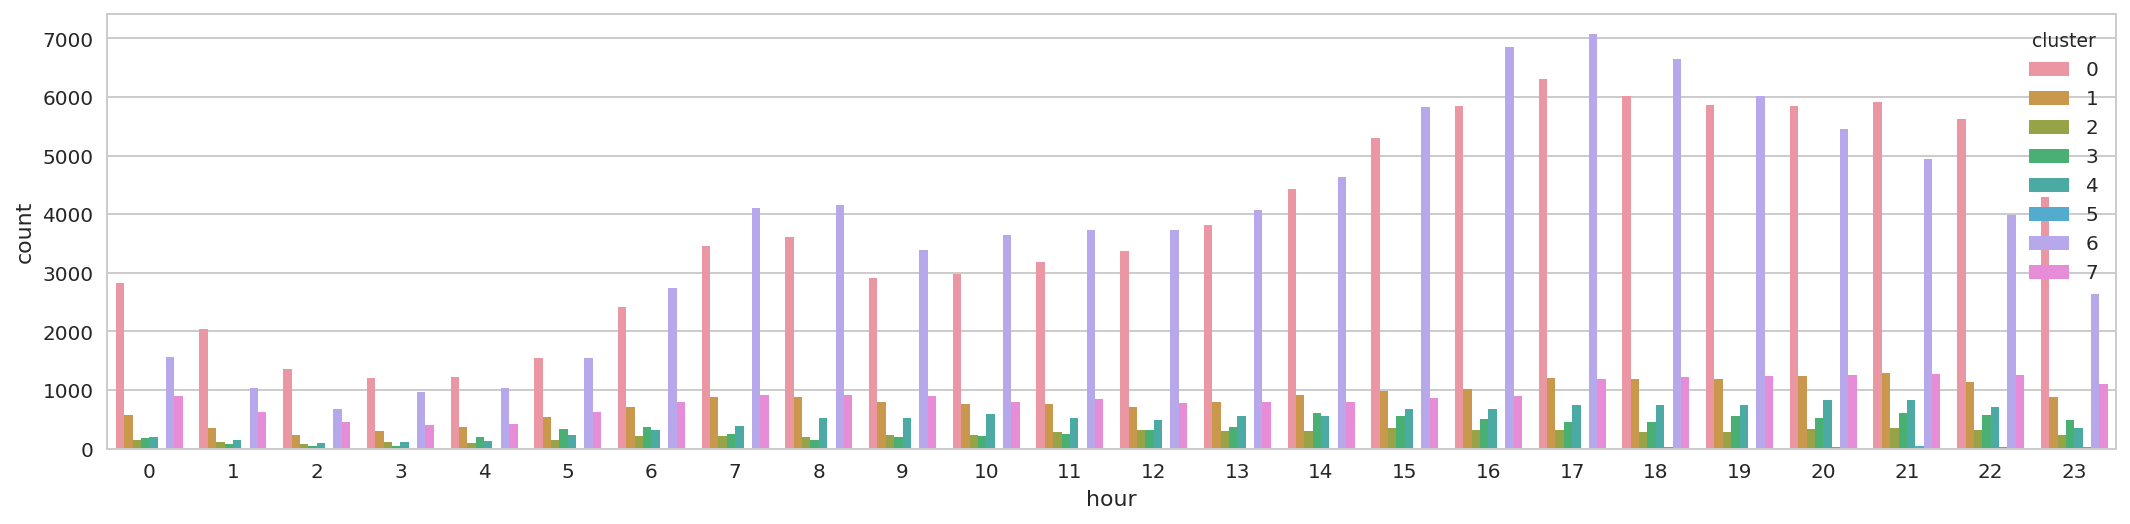

In [32]:
plt.figure(figsize=(18,4))
sns.barplot(x="hour", y="count", hue="cluster", data=sql_result_df.toPandas());

In [33]:
sql_result_df.unpersist()

DataFrame[hour: int, cluster: int, count: bigint]

**DF API:**

In [34]:
(test_preds
    .select(F.hour("dt").alias("hour"), "cluster")
    .groupBy(["hour", "cluster"])
    .count()
    .orderBy(F.desc("count"))).show(10)

+----+-------+-----+
|hour|cluster|count|
+----+-------+-----+
|  17|      6| 7068|
|  16|      6| 6849|
|  18|      6| 6641|
|  17|      0| 6314|
|  19|      6| 6019|
|  18|      0| 6014|
|  21|      0| 5923|
|  19|      0| 5862|
|  20|      0| 5853|
|  16|      0| 5849|
+----+-------+-----+
only showing top 10 rows



### 6.2 How many pickups occurred in each cluster?

**SQL:**

In [35]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT cluster, COUNT(cluster) AS count
                          |FROM test_preds
                          |GROUP BY cluster
                          |ORDER BY cluster
                        """))
sql_result_df.cache()

DataFrame[cluster: int, count: bigint]

In [36]:
sql_result_df.show(10)

+-------+-----+
|cluster|count|
+-------+-----+
|      0|91415|
|      1|19720|
|      2| 5765|
|      3| 8297|
|      4|11646|
|      5|  264|
|      6|90443|
|      7|21298|
+-------+-----+



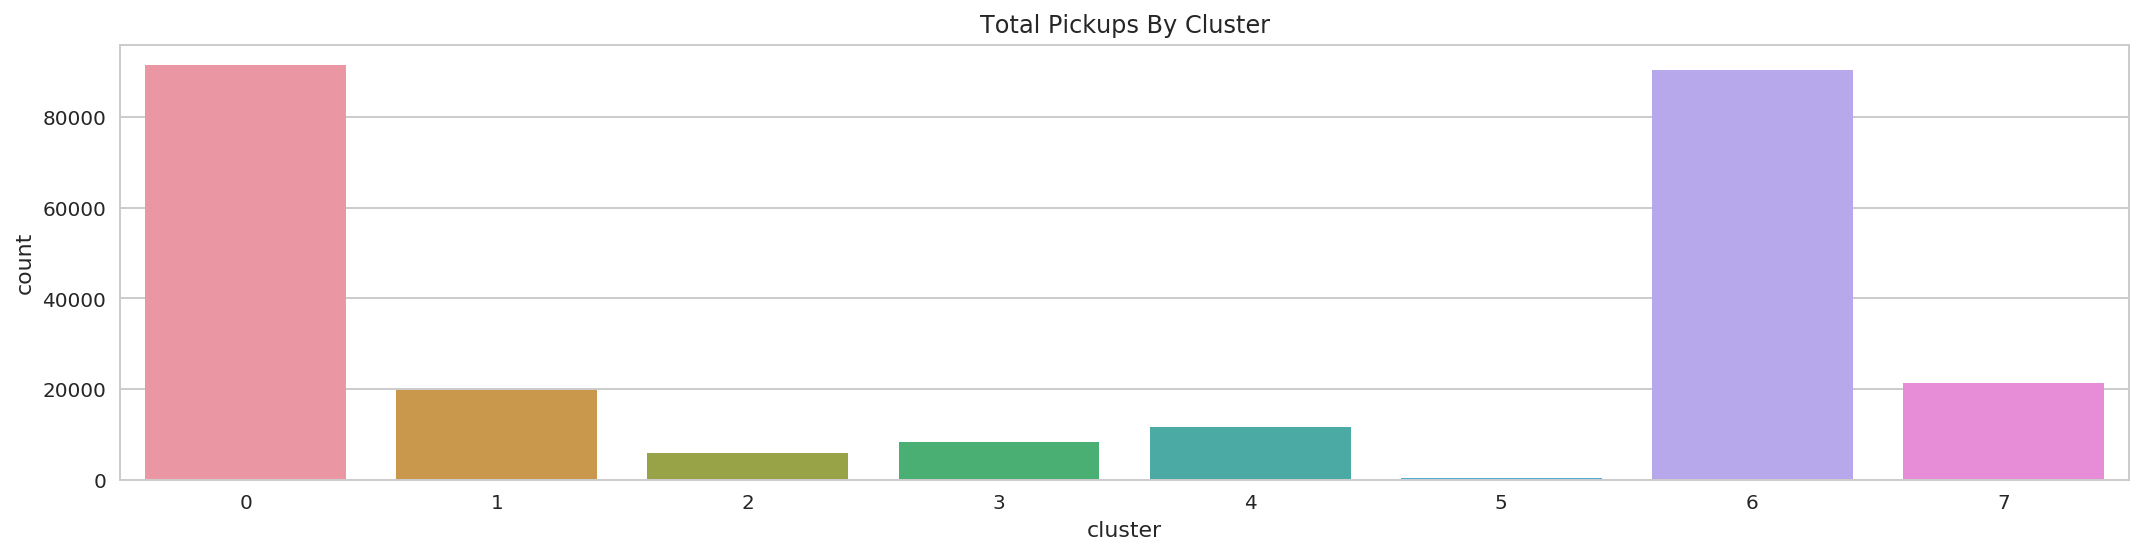

In [37]:
plt.figure(figsize=(18,4))
sns.barplot(x="cluster", y="count", data=sql_result_df.toPandas())
plt.title("Total Pickups By Cluster");

In [38]:
sql_result_df.unpersist()

DataFrame[cluster: int, count: bigint]

**DF API:**

In [39]:
(test_preds
    .groupBy("cluster")
    .count()
    .orderBy("cluster")).show(10)

+-------+-----+
|cluster|count|
+-------+-----+
|      0|91415|
|      1|19720|
|      2| 5765|
|      3| 8297|
|      4|11646|
|      5|  264|
|      6|90443|
|      7|21298|
+-------+-----+



### 6.3 How many pickups occurred in each hour?

**SQL:**

In [40]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT 
                          |    HOUR(dt) AS hour, 
                          |    COUNT(cluster) AS count
                          |FROM test_preds
                          |GROUP BY hour
                          |ORDER BY hour
                        """))
sql_result_df.cache()

DataFrame[hour: int, count: bigint]

In [41]:
sql_result_df.show(10)

+----+-----+
|hour|count|
+----+-----+
|   0| 6404|
|   1| 4373|
|   2| 2934|
|   3| 3132|
|   4| 3495|
|   5| 4980|
|   6| 7554|
|   7|10206|
|   8|10414|
|   9| 8959|
+----+-----+
only showing top 10 rows



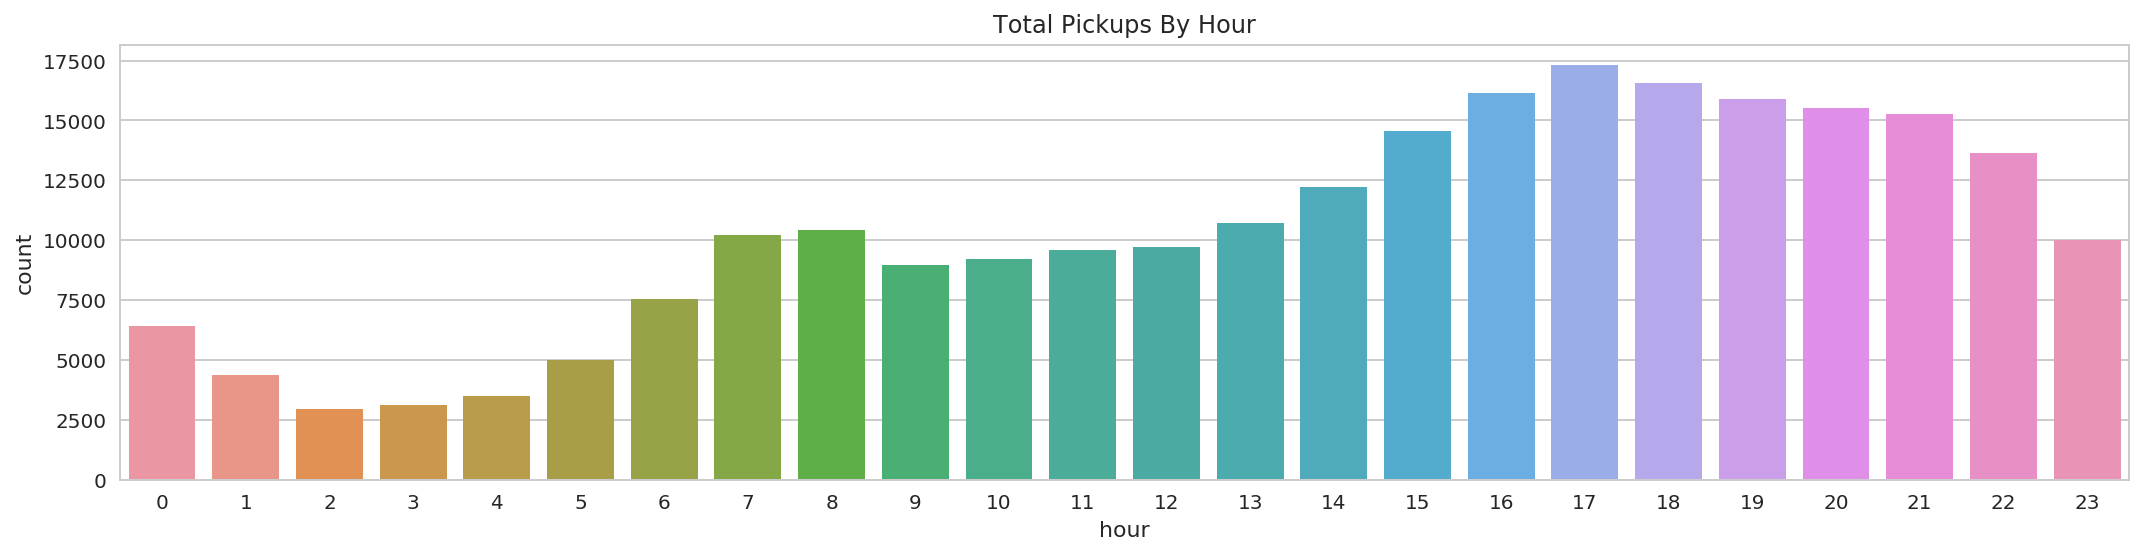

In [42]:
plt.figure(figsize=(18,4))
sns.barplot(x="hour", y="count", data=sql_result_df.toPandas())
plt.title("Total Pickups By Hour");

In [43]:
sql_result_df.unpersist()

DataFrame[hour: int, count: bigint]

**DF API:**

In [44]:
(test_preds
    .select(F.hour("dt").alias("hour"))
    .groupBy("hour")
    .count()
    .orderBy("hour")).show(10)

+----+-----+
|hour|count|
+----+-----+
|   0| 6404|
|   1| 4373|
|   2| 2934|
|   3| 3132|
|   4| 3495|
|   5| 4980|
|   6| 7554|
|   7|10206|
|   8|10414|
|   9| 8959|
+----+-----+
only showing top 10 rows



## 8. Bisecting k-means
`Bisecting k-means` is a variant of `k-means`. The core difference is that instead of clustering points by starting "bottom-up" and assigning a bunch of different groups in the data, this is a top-down clustering method. This means that it will start by creating a single group and then splitting that group into smaller groups in order to end up with the `k` number of clusters specified by the user. This is usually a faster method than `k-means` and will yield different results.

In [45]:
bkm = BisectingKMeans(featuresCol='features', predictionCol='cluster', maxIter=20, k=8)

In [46]:
bkm.explainParams()

"distanceMeasure: the distance measure. Supported options: 'euclidean' and 'cosine'. (default: euclidean)\nfeaturesCol: features column name. (default: features, current: features)\nk: The desired number of leaf clusters. Must be > 1. (default: 4, current: 8)\nmaxIter: max number of iterations (>= 0). (default: 20, current: 20)\nminDivisibleClusterSize: The minimum number of points (if >= 1.0) or the minimum proportion of points (if < 1.0) of a divisible cluster. (default: 1.0)\npredictionCol: prediction column name. (default: prediction, current: cluster)\nseed: random seed. (default: 6273406621647201097)"

In [47]:
bkmModel = bkm.fit(train_df)

In [48]:
bkmModel.transform(test_df).show(10)

+-------------------+-------+--------+------+------------------+-------+
|                 dt|    lat|     lon|  base|          features|cluster|
+-------------------+-------+--------+------+------------------+-------+
|2014-08-01 00:00:00|40.3495|-74.0667|B02682|[40.3495,-74.0667]|      0|
|2014-08-01 00:00:00|40.6754| -74.017|B02682| [40.6754,-74.017]|      1|
|2014-08-01 00:00:00|40.6759|-74.0168|B02617|[40.6759,-74.0168]|      1|
|2014-08-01 00:00:00|40.7303|-74.0029|B02682|[40.7303,-74.0029]|      1|
|2014-08-01 00:00:00|40.7424|-74.0044|B02598|[40.7424,-74.0044]|      1|
|2014-08-01 00:01:00|40.7052|-74.0094|B02598|[40.7052,-74.0094]|      1|
|2014-08-01 00:01:00|40.7108|-73.9679|B02598|[40.7108,-73.9679]|      1|
|2014-08-01 00:01:00|40.7341| -73.989|B02617| [40.7341,-73.989]|      1|
|2014-08-01 00:01:00|40.7552|-73.9724|B02682|[40.7552,-73.9724]|      2|
|2014-08-01 00:01:00|40.7633|-73.9891|B02617|[40.7633,-73.9891]|      2|
+-------------------+-------+--------+------+------

**Bisecting k-means Summary**

`Bisecting k-means` includes a summary class that we can use to evaluate our model, that is largely the same as the `k-means` summary. This includes information about the clusters created, as well as their relative sizes (number of examples):

In [49]:
print(bkmModel.summary.clusterSizes) # number of points

[6175, 278747, 189087, 61129, 18610, 1562, 23194, 1923]


In [50]:
bkmModel.computeCost(train_df)

772.3023226857927

In [51]:
print("Bisecting k-means Cluster Centers: ")
for center in bkmModel.clusterCenters():
    print(center)

Bisecting k-means Cluster Centers: 
[ 40.6693 -74.1934]
[ 40.7153 -73.9884]
[ 40.7574 -73.9807]
[ 40.7924 -73.9497]
[ 40.6561 -73.7797]
[ 40.7688 -73.4668]
[ 40.7657 -73.8626]
[ 40.979  -73.7823]


## Gaussian Mixture Models
`Gaussian mixture models (GMM)` are another popular clustering algorithm that makes different assumptions than `bisecting k-means` or `k-means` do. Those algorithms try to group data by reducing the sum of squared distances from the center of the cluster. Gaussian mixture models, on the other hand, assume that each cluster produces data based upon random draws from a Gaussian distribution. This means that clusters of data should be less likely to have data at the edge of the cluster (reflected in the Guassian distribution) and much higher probability of having data in the center. Each Gaussian cluster can be of arbitrary size with its own mean and standard deviation (and hence a possibly different, ellipsoid shape). There are still `k` user-specified clusters that will be created during training.

A simplified way of thinking about Gaussian mixture models is that they’re like a soft version of 𝘬-means. 𝘬-means creates very rigid clusters - each point is only within one cluster. GMMs allow for a more nuanced cluster associated with probabilities, instead of rigid boundaries.

In [52]:
gmm = GaussianMixture(featuresCol='features', predictionCol='cluster', k=8)

In [53]:
gmm.explainParams()

'featuresCol: features column name. (default: features, current: features)\nk: Number of independent Gaussians in the mixture model. Must be > 1. (default: 2, current: 8)\nmaxIter: max number of iterations (>= 0). (default: 100)\npredictionCol: prediction column name. (default: prediction, current: cluster)\nprobabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)\nseed: random seed. (default: 8705189966447162735)\ntol: the convergence tolerance for iterative algorithms (>= 0). (default: 0.01)'

In [54]:
gmmModel = gmm.fit(train_df)

In [55]:
gmmModel.transform(test_df).show(10)

+-------------------+-------+--------+------+------------------+-------+--------------------+
|                 dt|    lat|     lon|  base|          features|cluster|         probability|
+-------------------+-------+--------+------+------------------+-------+--------------------+
|2014-08-01 00:00:00|40.3495|-74.0667|B02682|[40.3495,-74.0667]|      3|[1.06308663207616...|
|2014-08-01 00:00:00|40.6754| -74.017|B02682| [40.6754,-74.017]|      4|[9.15865650722991...|
|2014-08-01 00:00:00|40.6759|-74.0168|B02617|[40.6759,-74.0168]|      4|[9.60775165626833...|
|2014-08-01 00:00:00|40.7303|-74.0029|B02682|[40.7303,-74.0029]|      7|[0.00138784100546...|
|2014-08-01 00:00:00|40.7424|-74.0044|B02598|[40.7424,-74.0044]|      6|[0.00112649565277...|
|2014-08-01 00:01:00|40.7052|-74.0094|B02598|[40.7052,-74.0094]|      1|[0.00107517269203...|
|2014-08-01 00:01:00|40.7108|-73.9679|B02598|[40.7108,-73.9679]|      4|[4.16398943190282...|
|2014-08-01 00:01:00|40.7341| -73.989|B02617| [40.7341,-73.9

**Gaussian Mixture Model Summary**

Like our other clustering algorithms, Gaussian mixture models include a summary class to help with model evaluation. This includes information about the clusters created, like the weights, the means, and the covariance of the Gaussian mixture, which can help us learn more about the underlying structure inside of our data:

In [56]:
gmmModel.weights

[0.033444679292671954,
 0.1907077608722158,
 0.09846089658833762,
 0.020507531179239213,
 0.15863651342428708,
 0.0192104771636125,
 0.19685292472549695,
 0.282179216754139]

In [57]:
gmmModel.gaussiansDF.limit(10).toPandas()

,mean,cov
0,"[40.8122891258, -73.948132837]","DenseMatrix([[ 0.0012, 0.0006],\n [ 0.0006, 0.0004]])"
1,"[40.7226007532, -73.9961921164]","DenseMatrix([[ 0.0001, 0.0001],\n [ 0.0001, 0.0001]])"
2,"[40.6940616769, -73.9107197668]","DenseMatrix([[ 0.0024, -0.0017],\n [-0.0017, 0.0148]])"
3,"[40.786598669, -73.8843730099]","DenseMatrix([[ 0.0255, 0.0091],\n [ 0.0091, 0.0559]])"
4,"[40.7043786628, -73.9624994418]","DenseMatrix([[ 0.0009, 0.0004],\n [ 0.0004, 0.0006]])"
5,"[40.7718590177, -73.8682761546]","DenseMatrix([[ 0., -0.],\n [-0., 0.]])"
6,"[40.7565713922, -73.9928070532]","DenseMatrix([[ 0.0004, 0.0002],\n [ 0.0002, 0.0001]])"
7,"[40.7542611718, -73.9776916525]","DenseMatrix([[ 0.0002, 0.0002],\n [ 0.0002, 0.0002]])"


In [58]:
print(gmmModel.summary.clusterSizes)

[14972, 120785, 47314, 7950, 96722, 11175, 118533, 162976]


In [59]:
gmmModel.summary.cluster.show(10)

+-------+
|cluster|
+-------+
|      3|
|      4|
|      2|
|      4|
|      4|
|      4|
|      1|
|      1|
|      1|
|      4|
+-------+
only showing top 10 rows



In [60]:
gmmModel.summary.probability.limit(10).toPandas()

,probability
0,"[1.06308663208e-13, 1.06308663208e-13, 1.13259982348e-10, 0.999999999886, 1.06308663208e-13, 1.06308663208e-13, 1.06308663208e-13, 1.06308663208e-13]"
1,"[2.57258559538e-13, 1.31857383539e-17, 0.155959876674, 0.00441320151399, 0.839626921812, 1.31857383467e-17, 1.31857383467e-17, 1.31857383467e-17]"
2,"[6.60625331474e-17, 6.60624841925e-17, 0.807242421341, 0.0226088865525, 0.170148692107, 6.60624841925e-17, 6.60624841925e-17, 6.60624841925e-17]"
3,"[1.03256700635e-06, 2.07043908927e-10, 0.0574508453329, 0.00175264171873, 0.940795480174, 5.22026489005e-18, 5.2202649101e-18, 5.22185401869e-18]"
4,"[6.70330357779e-08, 6.17953014992e-13, 0.0606290287811, 0.00181683549189, 0.937554068693, 5.35361245269e-18, 5.35361245269e-18, 5.35361264148e-18]"
5,"[1.68566376282e-15, 2.42308769481e-17, 0.28787510493, 0.00855777277577, 0.703567122294, 2.42308769477e-17, 2.42308769477e-17, 2.42308769477e-17]"
6,"[0.000558001653922, 0.923436925318, 0.00860096129908, 0.0003254051003, 0.00799715564531, 9.88264761474e-19, 0.0397719289251, 0.0193096220586]"
7,"[0.000915324237272, 0.973232017504, 0.00510028079851, 0.000192184935525, 0.012488620428, 5.63470906052e-19, 0.00097214507283, 0.00709942702433]"
8,"[0.000937241498729, 0.960671866484, 0.00442443745055, 0.000171071954326, 0.00868028103944, 4.99943986072e-19, 0.00353403892256, 0.0215810626508]"
9,"[5.03015669596e-07, 1.91361991824e-08, 0.0731236865718, 0.00285118563098, 0.924024605645, 7.68684305229e-18, 7.6868430523e-18, 2.95435029e-16]"


In [61]:
spark.stop()